In [1]:
import pandas as pd
from os import listdir
import numpy as np


In [2]:
import sklearn.metrics.pairwise
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import umap
import phate

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#PREPROCESSING:

In [5]:
temp = pd.read_feather('sample_var_phenos_leuk_topmed_v2.feather').set_index('sampleID').drop(columns=[
                                                                                                'CHIP_Gene', 
                                                                                                'AD', 
                                                                                                'AgeAt_All_Pneumonia', 
                                                                                                'AF', 
                                                                                                'Incd_Hypertension', 
                                                                                                'id'])

In [ ]:
#Check NAN values in all phenotypes:
i = -63
for nan  in temp.isna().sum().to_list()[-63:]:
    print(temp.columns[i], nan) #nan counts
    i += 1
    
del i

In [6]:
temp = temp.drop(columns=[
    'age',
    'age2',
    'PC1',
    'PC2',
    'PC3',
    'PC4',
    'PC5',
    'PC6',
    'PC7',
    'PC8',
    'PC9',
    'PC10',
    'Prev_Coronary_Artery_Disease_SOFT',
    'Incd_Coronary_Artery_Disease_SOFT',
    'Coronary_Artery_Disease_SOFT_FollowUp',
    'Death',
    'Prev_Death',
    'Incd_Death',
    'Death_FollowUp',
    'Diabetes_All',
    'Prev_Diabetes_All',
    'Incd_Diabetes_All',
    'Diabetes_All_FollowUp',
    'Prev_Diabetes_Type_1',
    'Incd_Diabetes_Type_1',
    'Diabetes_Type_1_FollowUp',
    'Prev_Diabetes_Type_2',
    'Incd_Diabetes_Type_2',
    'Diabetes_Type_2_FollowUp',
    'Prev_Heart_Failure',
    'Incd_Heart_Failure',
    'Heart_Failure_FollowUp',
    'Prev_Hypercholesterolemia',
    'Incd_Hypercholesterolemia',
    'Hypercholesterolemia_FollowUp',
    'Prev_Hypertension',
    'Hypertension_FollowUp',
    'Prev_AML',
    'Incd_AML',
    'AML_FollowUp',
    'Prev_MPN',
    'Incd_MPN',
    'MPN_FollowUp',
    'Incd_All_Pneumonia',
    'All_Pneumonia_FollowUp',
    'Prev_All_Pneumonia',
    'Platelet count',
    'Platelet crit',
    'Mean platelet volume',
    'Platelet distribution width']).dropna()

In [7]:
phenotypes = temp[[
                    'Hypercholesterolemia',
                    'Hypertension',
                    'hasCHIP',
                    'AML',
                    'MPN',
                    'All_Pneumonia',
                    'Sex_numeric',
                    'SmokingStatus',
                    'ever_smoked',
                    'Coronary_Artery_Disease_SOFT',
                    'Diabetes_Type_1',
                    'Diabetes_Type_2',
                    'Heart_Failure']]

data = temp.drop(columns=[
                            'Hypercholesterolemia',
                            'Hypertension',
                            'hasCHIP',
                            'AML',
                            'MPN',
                            'All_Pneumonia',
                            'Sex_numeric',
                            'SmokingStatus',
                            'ever_smoked',
                            'Coronary_Artery_Disease_SOFT',
                            'Diabetes_Type_1',
                            'Diabetes_Type_2',
                            'Heart_Failure'])
del temp

In [ ]:
jaccard = sklearn.metrics.pairwise_distances(data.values, metric='jaccard', n_jobs=-1)

In [ ]:
#VISUALISATION:

In [9]:
#PCA without data normalization
#not using phenotypes for my clustering methods, instead using them as labels
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pca_scaled = PCA()
X_pca_scaled = pca_scaled.fit_transform(data_scaled)

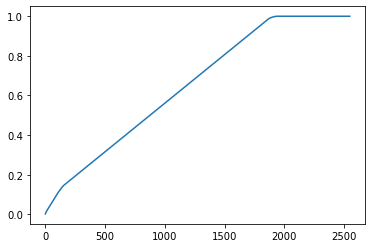

In [10]:
#Adjust number of PCs used in the future analyses according to this graph:
plt.plot(np.cumsum(pca_scaled.explained_variance_ratio_))

In [11]:
sum(pca_scaled.explained_variance_ratio_[0:1800])

0.9538674498788412

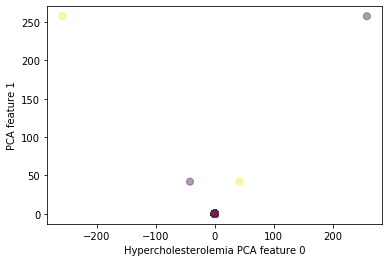

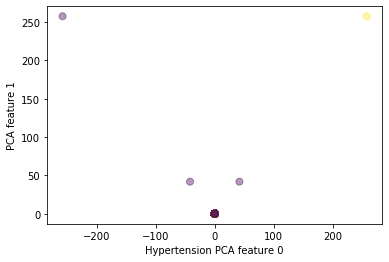

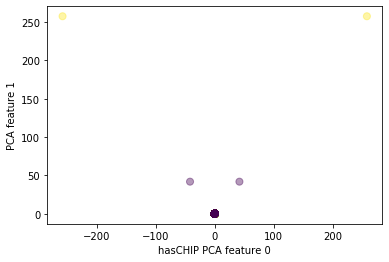

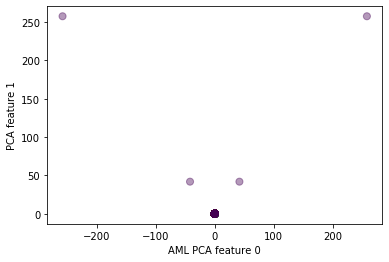

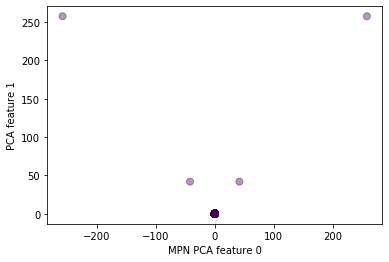

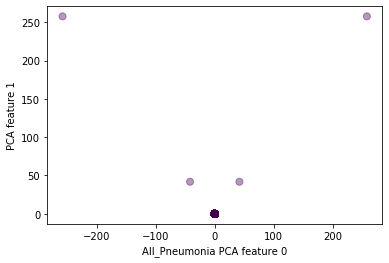

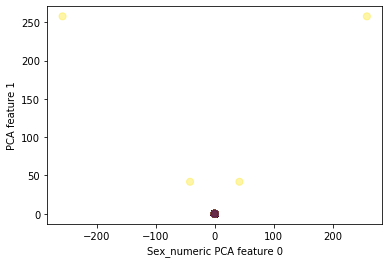

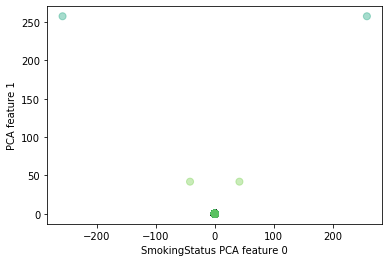

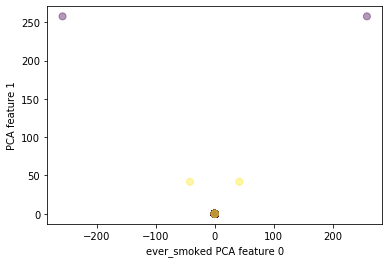

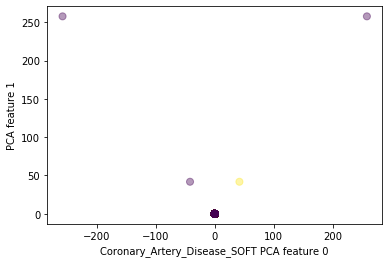

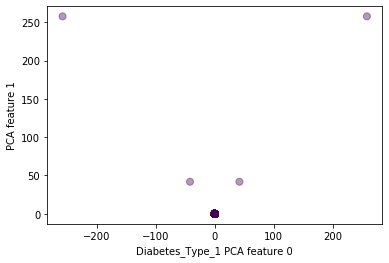

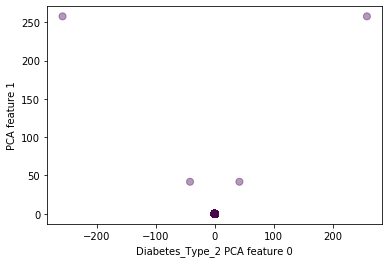

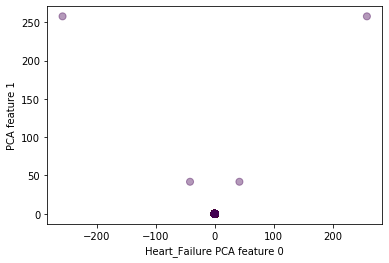

In [12]:
#Plot PC0 vs PC1 -- can play with other PCs:
for phenotype in phenotypes.columns:
    plt.figure()
    plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=phenotypes[phenotype], s=50, alpha=.4) #s = size, alpha = transparency 
    plt.xlabel(phenotype + " PCA feature 0")
    plt.ylabel("PCA feature 1")
    # Show/save figure as desired.
    plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()

In [ ]:
#If necessary, use only a portion of the data:
# reduced_pca = np.vstack((X_pca_scaled[phenotypes.hasCHIP == 1], X_pca_scaled[phenotypes.hasCHIP == 0][0:9000,:]))
# reduced_pca_notsc = np.vstack((X_pca[phenotypes.hasCHIP == 1], X_pca[phenotypes.hasCHIP == 0][0:9000,:]))
#replace data.hasCHIP by phenotype of interest and adjust 9000 to some other number

In [ ]:
#T-SNE:
tsne = TSNE(random_state=42, n_components=2, metric='jaccard')
tsne_data = tsne.fit_transform(data)#adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data

In [ ]:
#T-SNE:
tsne = TSNE(random_state=42, n_components=2)
tsne_data = tsne.fit_transform(data_scaled)#adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data

In [ ]:
for phenotype in phenotypes:
    plt.figure(figsize=(10, 10))
    plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max() + 1) #decrease '1' if the graph looks empty
    plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max() + 1)

    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=phenotypes[phenotype], s=4, alpha=.5) #s = size, alpha = transparency 
    plt.xlabel(phenotype + " t-SNE feature 0")
    plt.ylabel("t-SNE feature 1")
    # Show/save figure as desired.
    plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()

In [ ]:
#UMAP
reducer = umap.UMAP(random_state=42, metric='jaccard')
embedding = reducer.fit_transform(data) 

In [ ]:
for phenotype in phenotypes.columns:
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=phenotypes[phenotype], s=2, alpha=.4)
    plt.xlabel(phenotype + " feature 0")
    plt.ylabel("feature 1")
    # Show/save figure as desired.
    plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()

In [ ]:
#PHATE:
phate_op = phate.PHATE(n_jobs=-1, knn_dist='jaccard', mds_dist='jaccard') #adjust the num of PCs according to the variance covered#T-SNE:
data_phate = phate_op.fit_transform(data)

In [ ]:
for phenotype in phenotypes:
    phate.plot.scatter2d(data_phate, c=phenotypes[phenotype], s=10, alpha=.3)

In [ ]:
#CLUSTERING

In [ ]:
#Kmeans:
kmeans = KMeans(n_jobs=-1) #can play with n_clusters= and max_iter=; default is 8 and 300 respectively
kmeans.fit(data) #adjust 1900 to number of PCs#T-SNE:
#means.fit(jaccard)

In [ ]:
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
plt.figure()
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans.labels_, s=2, alpha=.4) #or try t-sne/UMAP 
plt.show()

In [ ]:
print("Hypercholesterolemia= ", adjusted_rand_score(phenotypes.Hypercholesterolemia == 1, kmeans.labels_))  
print("CHIP= ", adjusted_rand_score(phenotypes.hasCHIP == 1, kmeans.labels_))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, kmeans.labels_))
print("AML= ", adjusted_rand_score(phenotypes.AML == 1, kmeans.labels_))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, kmeans.labels_))
print("MPN= ", adjusted_rand_score(phenotypes.MPN == 1, kmeans.labels_))
print("All_Pneumonia= ", adjusted_rand_score(phenotypes.All_Pneumonia == 1, kmeans.labels_))
print("SmokingStatus= ", adjusted_rand_score(phenotypes.SmokingStatus == 1, kmeans.labels_))
print("Coronary_Artery_Disease_SOFT= ", adjusted_rand_score(phenotypes.Coronary_Artery_Disease_SOFT == 1, kmeans.labels_))
print("Diabetes_Type_1= ", adjusted_rand_score(phenotypes.Diabetes_Type_1 == 1, kmeans.labels_))
print("Diabetes_Type_2= ", adjusted_rand_score(phenotypes.Diabetes_Type_2 == 1, kmeans.labels_))
print("Heart_Failure= ", adjusted_rand_score(phenotypes.Heart_Failure == 1, kmeans.labels_))

In [ ]:
#Agglomerative-Ward
agg = AgglomerativeClustering() #can play with (e.g., n_clusters=2); default is 8
assignment = agg.fit_predict(data) #adjust 1900 to number of PCs#T-SNE:
# assignment = agg.fit_predict(jaccard) #adjust 1900 to number of PCs#T-SNE:

In [ ]:
(unique, counts) = np.unique(assignment, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
plt.figure()
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=assignment, s=2, alpha=.4)
plt.show()

In [ ]:
print("Hypercholesterolemia= ", adjusted_rand_score(phenotypes.Hypercholesterolemia == 1, assignment))   
print("CHIP= ", adjusted_rand_score(phenotypes.hasCHIP == 1, assignment))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, assignment))
print("AML= ", adjusted_rand_score(phenotypes.AML == 1, assignment))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, assignment))
print("MPN= ", adjusted_rand_score(phenotypes.MPN == 1, clusters))
print("All_Pneumonia= ", adjusted_rand_score(phenotypes.All_Pneumonia == 1, assignment))
print("SmokingStatus= ", adjusted_rand_score(phenotypes.SmokingStatus == 1, assignment))
print("Coronary_Artery_Disease_SOFT= ", adjusted_rand_score(phenotypes.Coronary_Artery_Disease_SOFT == 1, assignment))
print("Diabetes_Type_1= ", adjusted_rand_score(phenotypes.Diabetes_Type_1 == 1, assignment))
print("Diabetes_Type_2= ", adjusted_rand_score(phenotypes.Diabetes_Type_2 == 1, assignment))
print("Heart_Failure= ", adjusted_rand_score(phenotypes.Heart_Failure == 1, assignment))

In [ ]:
#Agglomerative-Complete
agg = AgglomerativeClustering(linkage="complete", affinity='precomputed') #can play with (e.g., n_clusters=2); default is 8
assignment = agg.fit_predict(jaccard) #adjust 1900 to number of PCs#T-SNE:

In [ ]:
(unique, counts) = np.unique(assignment, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
plt.figure()
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=assignment, s=2, alpha=.4)
plt.show()

In [ ]:
print("Hypercholesterolemia= ", adjusted_rand_score(phenotypes.Hypercholesterolemia == 1, assignment)) 
print("CHIP= ", adjusted_rand_score(phenotypes.hasCHIP == 1, assignment))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, assignment))
print("AML= ", adjusted_rand_score(phenotypes.AML == 1, assignment))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, assignment))
print("MPN= ", adjusted_rand_score(phenotypes.MPN == 1, clusters))
print("All_Pneumonia= ", adjusted_rand_score(phenotypes.All_Pneumonia == 1, assignment))
print("SmokingStatus= ", adjusted_rand_score(phenotypes.SmokingStatus == 1, assignment))
print("Coronary_Artery_Disease_SOFT= ", adjusted_rand_score(phenotypes.Coronary_Artery_Disease_SOFT == 1, assignment))
print("Diabetes_Type_1= ", adjusted_rand_score(phenotypes.Diabetes_Type_1 == 1, assignment))
print("Diabetes_Type_2= ", adjusted_rand_score(phenotypes.Diabetes_Type_2 == 1, assignment))
print("Heart_Failure= ", adjusted_rand_score(phenotypes.Heart_Failure == 1, assignment))

In [ ]:
#Agglomerative-Average
agg = AgglomerativeClustering(linkage="average", affinity='precomputed') #can play with (e.g., n_clusters=2); default is 8
assignment = agg.fit_predict(jaccard) #adjust 1900 to number of PCs#T-SNE:

In [ ]:
(unique, counts) = np.unique(assignment, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
plt.figure()
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=assignment, s=2, alpha=.4)
plt.show()

In [ ]:
print("Hypercholesterolemia= ", adjusted_rand_score(phenotypes.Hypercholesterolemia == 1, assignment)) 
print("CHIP= ", adjusted_rand_score(phenotypes.hasCHIP == 1, assignment))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, assignment))
print("AML= ", adjusted_rand_score(phenotypes.AML == 1, assignment))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, assignment))
print("MPN= ", adjusted_rand_score(phenotypes.MPN == 1, clusters))
print("All_Pneumonia= ", adjusted_rand_score(phenotypes.All_Pneumonia == 1, assignment))
print("SmokingStatus= ", adjusted_rand_score(phenotypes.SmokingStatus == 1, assignment))
print("Coronary_Artery_Disease_SOFT= ", adjusted_rand_score(phenotypes.Coronary_Artery_Disease_SOFT == 1, assignment))
print("Diabetes_Type_1= ", adjusted_rand_score(phenotypes.Diabetes_Type_1 == 1, assignment))
print("Diabetes_Type_2= ", adjusted_rand_score(phenotypes.Diabetes_Type_2 == 1, assignment))
print("Heart_Failure= ", adjusted_rand_score(phenotypes.Heart_Failure == 1, assignment))

In [ ]:
#DBSCAN:
dbscan = DBSCAN(n_jobs=-1, metric='jaccard')
clusters = dbscan.fit_predict(X_pca_scaled[:, 0:1900]) #adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data

In [ ]:
(unique, counts) = np.unique(clusters, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
plt.figure()
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=clusters, s=2, alpha=.4)
plt.show()

In [ ]:
print("Hypercholesterolemia= ", adjusted_rand_score(phenotypes.Hypercholesterolemia == 1, clusters))   
print("CHIP= ", adjusted_rand_score(phenotypes.hasCHIP == 1, clusters))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, clusters))
print("AML= ", adjusted_rand_score(phenotypes.AML == 1, clusters))
print("Hypertension= ", adjusted_rand_score(phenotypes.Hypertension == 1, clusters))
print("MPN= ", adjusted_rand_score(phenotypes.MPN == 1, clusters))
print("All_Pneumonia= ", adjusted_rand_score(phenotypes.All_Pneumonia == 1, clusters))
print("SmokingStatus= ", adjusted_rand_score(phenotypes.SmokingStatus == 1, clusters))
print("Coronary_Artery_Disease_SOFT= ", adjusted_rand_score(phenotypes.Coronary_Artery_Disease_SOFT == 1, clusters))
print("Diabetes_Type_1= ", adjusted_rand_score(phenotypes.Diabetes_Type_1 == 1, clusters))
print("Diabetes_Type_2= ", adjusted_rand_score(phenotypes.Diabetes_Type_2 == 1, clusters))
print("Heart_Failure= ", adjusted_rand_score(phenotypes.Heart_Failure == 1, clusters))

In [ ]:
# #COMPARE CLUSTERING ALGOS:
# fig, axes = plt.subplots(1, 6, figsize=(15, 3),
#                          subplot_kw={'xticks': (), 'yticks': ()})

# # make a list of algorithms to use
# algorithms = [KMeans(n_jobs=-1, n_clusters=2), 
#               AgglomerativeClustering(n_clusters=2), 
#               AgglomerativeClustering(n_clusters=2, linkage="complete"),
#               AgglomerativeClustering(n_clusters=2, linkage="average"),
#               DBSCAN()]

# # create a random cluster assignment for reference
# random_state = np.random.RandomState(seed=0)
# random_clusters = random_state.randint(low=0, high=2, size=len(data))

# # plot random assignment
# axes[0].scatter(data_phate[:, 0], data_phate[:, 1], c=random_clusters, s=60)#use the best vis. techniq (e.g, UMAP, PHATE, t-sne instead of PCs)
# axes[0].set_title("Random assignment - ARI: {:.2f}".format(adjusted_rand_score(phenotypes.hasCHIP == 1, random_clusters)))

# for ax, algorithm in zip(axes[1:], algorithms):
#     # plot the cluster assignments and cluster centers
#     clusters = algorithm.fit_predict(X_pca_scaled[:, 0:1900])#adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data
#     ax.scatter(data_phate[:, 0], data_phate[:, 1], c=clusters, s=1)#use the best vis. techniq (e.g, UMAP, PHATE, t-sne instead of PCs)
#     ax.set_title("{}={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.hasCHIP == 1, clusters)))
    
#     print("{}; Hypercholesterolemia={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Hypercholesterolemia == 1, clusters)))    
#     print("{}; Hypertension={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Hypertension == 1, clusters)))
#     print("{}; AML={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.AML == 1, clusters)))
#     print("{}; Hypertension={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Hypertension == 1, clusters)))
#     print("{}; MPN={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.MPN == 1, clusters)))
#     print("{}; All_Pneumonia={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.All_Pneumonia == 1, clusters)))
#     print("{}; SmokingStatus={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.SmokingStatus == 1, clusters)))
#     print("{}; Coronary_Artery_Disease_SOFT={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Coronary_Artery_Disease_SOFT == 1, clusters)))
#     print("{}; Diabetes_Type_1={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Diabetes_Type_1 == 1, clusters)))
#     print("{}; Diabetes_Type_2={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Diabetes_Type_2 == 1, clusters)))
#     print("{}; Heart_Failure={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Heart_Failure == 1, clusters)))                                               